#**Auto Inland Vehicule Insurance Claim Challenge**

# Importing libraries

In [ ]:
!pip install plotly
!pip install catboost

In [50]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_recall_curve, f1_score, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


from sklearn.feature_selection import VarianceThreshold

import warnings
warnings.filterwarnings('ignore')
from collections import Counter 

import random
random.seed(123)

# Reading the data into python¶


In [3]:
# Load files into a pandas dataframe
train = pd.read_csv('Train.csv')
train.head(3)

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0


In [4]:
test = pd.read_csv('Test.csv')
test.head(3)

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic


In [5]:
ss = pd.read_csv('SampleSubmission.csv')
ss.head()

,ID,target
0,ID_01QM0NU,0
1,ID_024NJLZ,0
2,ID_02NOVWQ,0
3,ID_02VSP68,0
4,ID_02YB37K,0


# Defining the problem statement:
Create a Predictive model which can tell if a client will submit a vehicle insurance claim in the next 3 months


*   Target Variable: Target
*   Predictors: Car_Category, Age, etc.


\
*   Yes = 1 
*   No = 0 

Based on the problem statement, we need to create a supervised ML classification model as the target variable is categorical.

#Looking at the distribution of Target variable

0    10624
1     1455
Name: target, dtype: int64


Text(0.5, 1.0, 'Target Distribution')

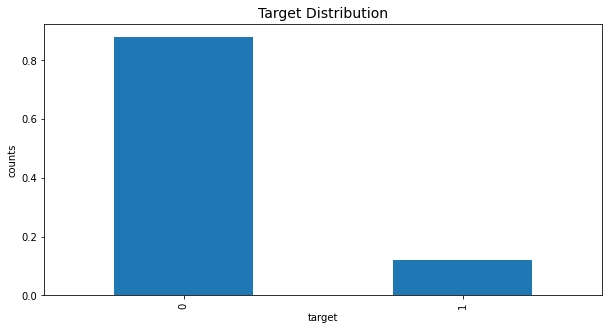

In [8]:
print(train['target'].value_counts())
plt.figure(figsize=(10,5))
train['target'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('target')
plt.title('Target Distribution', fontdict={'size':14})

~87% of the clients in the dataset did not submit a vehicle insurance claim whereas ~12% did. 

=> imbalanced dataset

# Combine train and test set for easy preprocessing 

In [14]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (13281, 14)


#### Removing duplicate rows if any

In [15]:
print('Shape of the training set before deleting duplicate values:', all_data.shape)

all_data = all_data.drop_duplicates()
print('Shape After deleting duplicate values:', all_data.shape)

Shape of the training set before deleting duplicate values: (13281, 14)
Shape After deleting duplicate values: (13281, 14)


# Data Exploration + Preprocessing

In [16]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      13281 non-null  object 
 1   Policy Start Date       13281 non-null  object 
 2   Policy End Date         13281 non-null  object 
 3   Gender                  12881 non-null  object 
 4   Age                     13281 non-null  int64  
 5   First Transaction Date  13281 non-null  object 
 6   No_Pol                  13281 non-null  int64  
 7   Car_Category            9171 non-null   object 
 8   Subject_Car_Colour      5622 non-null   object 
 9   Subject_Car_Make        10557 non-null  object 
 10  LGA_Name                6149 non-null   object 
 11  State                   6137 non-null   object 
 12  ProductName             13281 non-null  object 
 13  target                  12079 non-null  float64
dtypes: float64(1), int64(2), object(11)
me

#### Change each column to its appriopriate datatype


In [18]:
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col]) # 'datetime64'for the dates 
  elif col in cat_cols:
    all_data[col] = all_data[col].astype('category') # change 'object' dtype to 'category'

# Confirm whether the changes have been applied successfully
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      13281 non-null  object        
 1   Policy Start Date       13281 non-null  datetime64[ns]
 2   Policy End Date         13281 non-null  datetime64[ns]
 3   Gender                  12881 non-null  category      
 4   Age                     13281 non-null  int64         
 5   First Transaction Date  13281 non-null  datetime64[ns]
 6   No_Pol                  13281 non-null  int64         
 7   Car_Category            9171 non-null   category      
 8   Subject_Car_Colour      5622 non-null   category      
 9   Subject_Car_Make        10557 non-null  category      
 10  LGA_Name                6149 non-null   category      
 11  State                   6137 non-null   category      
 12  ProductName             13281 non-null  catego

####Categorical variables 

In [19]:
all_data.Gender.unique()

['Male', 'Female', 'Entity', 'Joint Gender', NaN, 'NO GENDER', 'NOT STATED', 'SEX']
Categories (7, object): ['Male', 'Female', 'Entity', 'Joint Gender', 'NO GENDER', 'NOT STATED',
                         'SEX']

In [20]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

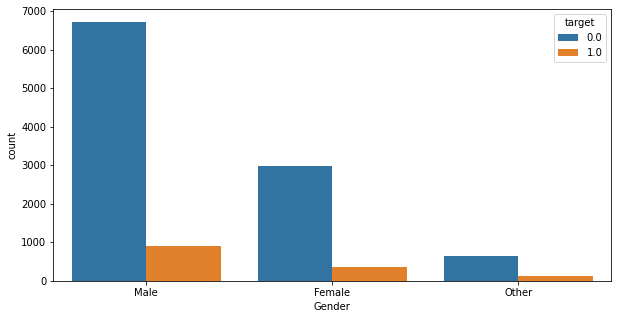

In [21]:
plt.figure(figsize=(10,5))
sns.countplot("Gender", hue="target", data=all_data)

In [23]:
mapper = {'Mini Bus':'Bus', 'Mini Van':'Van', 'Pick Up > 3 Tons':'Pick Up',
          'Tipper Truck':'Truck', 'Sedan':'Other', 'CAMRY CAR HIRE':'Other',
          'Station 4 Wheel':'Other', 'Shape Of Vehicle Chasis':'Other',
          'Wagon':'Other'}
all_data.Car_Category = all_data.Car_Category.replace(mapper)

In [24]:
'''for i in all_data.Car_Category.unique():
  print(i)'''

'for i in all_data.Car_Category.unique():\n  print(i)'

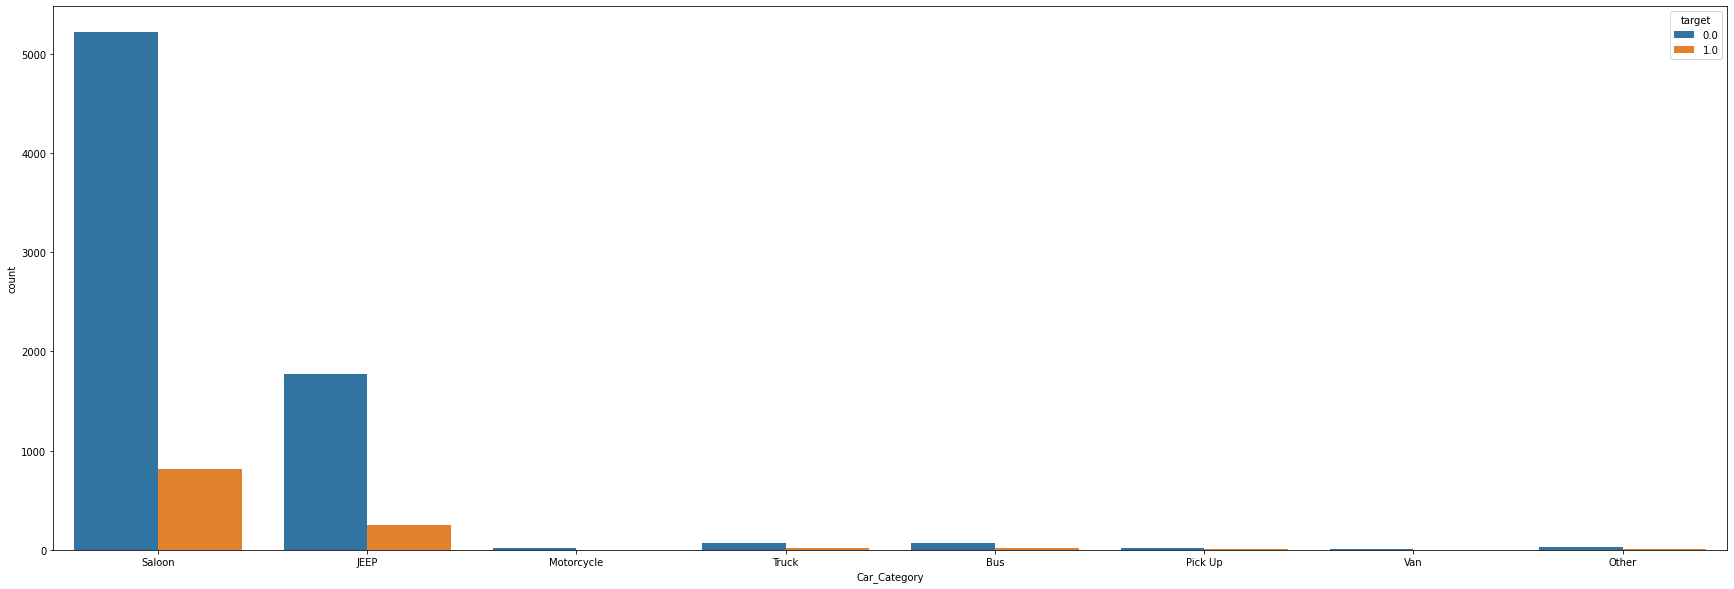

In [25]:
plt.figure(figsize=(30,10))
sns.countplot("Car_Category", hue='target',data=all_data)

In [26]:
all_data.Subject_Car_Make.value_counts()

TOYOTA        5466
Honda         1146
Lexus          654
Mercedes       577
Hyundai        512
              ... 
REXTON           1
Raston           1
Rols Royce       1
Tata             1
Jincheng         1
Name: Subject_Car_Make, Length: 75, dtype: int64

In [27]:
all_data.State.unique()

[NaN, 'Lagos', 'Benue', 'Eti-Osa', 'Delta', ..., 'ENUGU-SOUTH', 'Ijebu-North', 'Asari-Toru', 'Idemili-south', 'Ngor-Okpala']
Length: 114
Categories (113, object): ['Lagos', 'Benue', 'Eti-Osa', 'Delta', ..., 'Ijebu-North', 'Asari-Toru',
                           'Idemili-south', 'Ngor-Okpala']

In [28]:
all_data['State'] = all_data['State'].replace({'Abuja-Municipal':'Federal Capital Territory','Oshodi-Isolo':'Lagos','Ibeju-Lekki':'Lagos','Ibadan-West':'Ibadan','Eti-Osa':'Lagos'
                                        ,'Obia-Akpor':'Awka-Ibom','Ibadan-East':'Oyo','Amuwo-Odofin':'Lagos','ENUGU-EAST':'Enugu','Esan-West':'Edo'
                                         ,'Obafemi-Owode':'Ogun','Orile-Iganmu':'Lagos', 'Ifako-Ijaye':'Lagos', 'Ibadan-North':'Oyo',
                                         'Jos-North':'Plateau'
                                        , 'Ondo-West':'Ondo', 'Kaduna-North':'Kaduna','Aniocha-South':'Delta','Ile-Oluji':'Ondo','Nnewi-North':'Anambra'
                                        ,'Aboh-Mbaise':'Imo', 'Akoko-West':'Ondo','Warri-Central':'Edo', 'Jos-South':'Plateus','Onitsha-North':'Anambra'
                                        , 'Ajeromi-Ifelodun':'Osun', 'Kano-Municipal':'Kano','Ife-Central':'Osun','Ilorin-West':'Kwara'
                                         ,'Lagelu-North':'Oyo', 'Owerri-Municipal':'Imo','Nsit-Ubium':'Awka-Ibom', 'Udi-Agwu':'Enugu',
                                         'Owerri-West':'Imo'
                                         ,'Ogbmosho-South':'Oyo', 'Umuahia-South':'Abia','Ajegunle-State':'Lagos','Ekiti-West':'Ekiti',
                                         'Ogun-Waterside':'Ogun'
                                        ,'Awka-North':'Anambra','ABULE-EGBA':'Lagos','Ife-North':'Osun', 'Anambra-East':'Anambra', 'Etsako-West':'Edo'
                                         ,'Aba-North':'Abia','Ibarapa-Central':'Oyo', 'Idemili-North':'Anambra', 'Ogba-Ndoni':'Rivers', 
                                         'Calabar-Municipality':'Cross-River','AJAO-ESTATE':'Lagos','Ekiti-East':'Ekiti',
                                         'Ovia-SouthWest':'Edo','Essien-Udim':'Akwa-Ibom',
                                         'Ado-Ota':'Ogun', 'Oyo-East':'Oyo', 'Ilorin-East':'Kwara', 'Ilesha-West':'Osun', 'Central-Abuja':'Federal Capital Territory',
                                         'Owerri-North':'Imo','Ilesha-East':'Osun', 'Awka-South':'Delta','Enugu-North':'Enugu','Ibadan':'Oyo',
                                         'Esan-Central':'Edo', 'Isoko-south':'Delta', 'Ethiope-East':'Delta','Ijebu-Ode':'Ogun'
                                         ,'QuaAn-Pan':'Plateus', 'Warri-North':'Delta', 'Ado-Ekiti':'Ekiti', 'Ijebu-East':'Ogun',
                                         'Onitsha-South':'Anambra', 'Ughelli-North':'Delta', 'Warri-South':'Delta', 'Kaduna-South':'Kaduna',
                                         'Port-Harcourt':'Rivers', 'N-A':np.NaN, 'Idemili-south': 'Anambra', 'Ngor-Okpala':'Imo',
      
                                         'Oyo-West':'Oyo', 'Aba-South':'Abia', 'Isoko-North':'Delta', 'Oshimili-North':'Delta',
                                         'Ndokwa-East':'Delta', 'Nnewi-South':'Anambra', 'ENUGU-SOUTH':'Enugu', 'Ijebu-North':'Ogun',
                                         'Asari-Toru':'Rivers', 'Akwa-Ibom':'Awka-Ibom'})

In [29]:
all_data['State'].unique()

array([nan, 'Lagos', 'Benue', 'Delta', 'Ogun',
       'Federal Capital Territory', 'Ibadan', 'Awka-Ibom', 'Oyo',
       'Kaduna', 'Anambra', 'Rivers', 'Niger-State', 'Edo', 'Enugu',
       'Abuja', 'Imo', 'Plateau', 'Ondo', 'Cross-River', 'Plateus',
       'Osun', 'Kano', 'Kwara', 'Akwa-Ibom', 'Abia', 'Kebbi', 'Ekiti',
       'Nasarawa', 'Gombe', 'Bayelsa', 'Kogi', 'Bauchi', 'Ebonyi'],
      dtype=object)

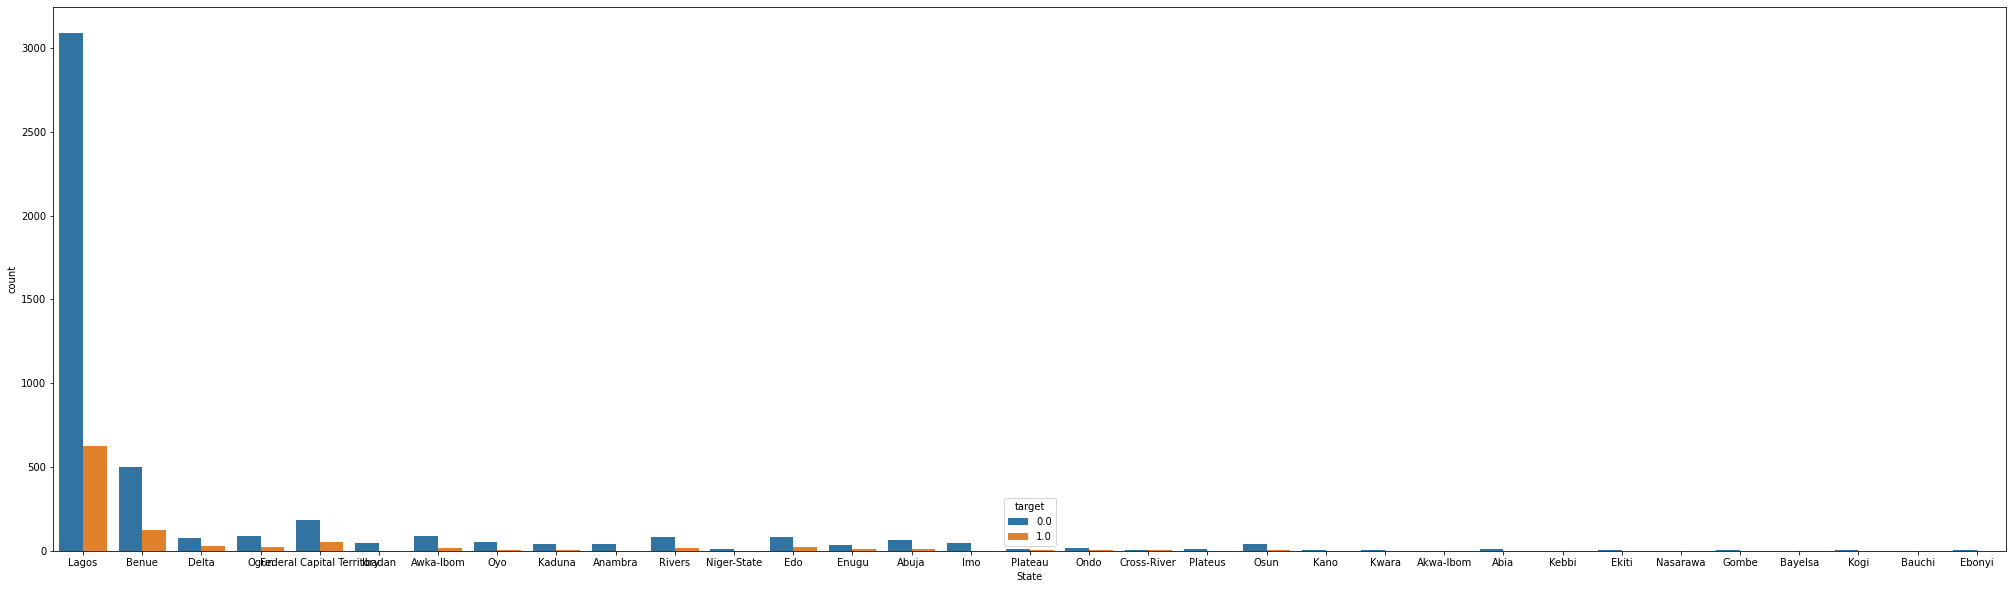

In [30]:
plt.figure(figsize=(35,10))
sns.countplot("State", hue='target',data=all_data)

In [31]:
all_data['ProductName'].unique()

['Car Classic', 'CarSafe', 'Muuve', 'CVTP', 'Car Plus', 'Motor Cycle', 'Customized Motor', 'CarFlex', 'Car Vintage']
Categories (9, object): ['Car Classic', 'CarSafe', 'Muuve', 'CVTP', ..., 'Motor Cycle',
                         'Customized Motor', 'CarFlex', 'Car Vintage']

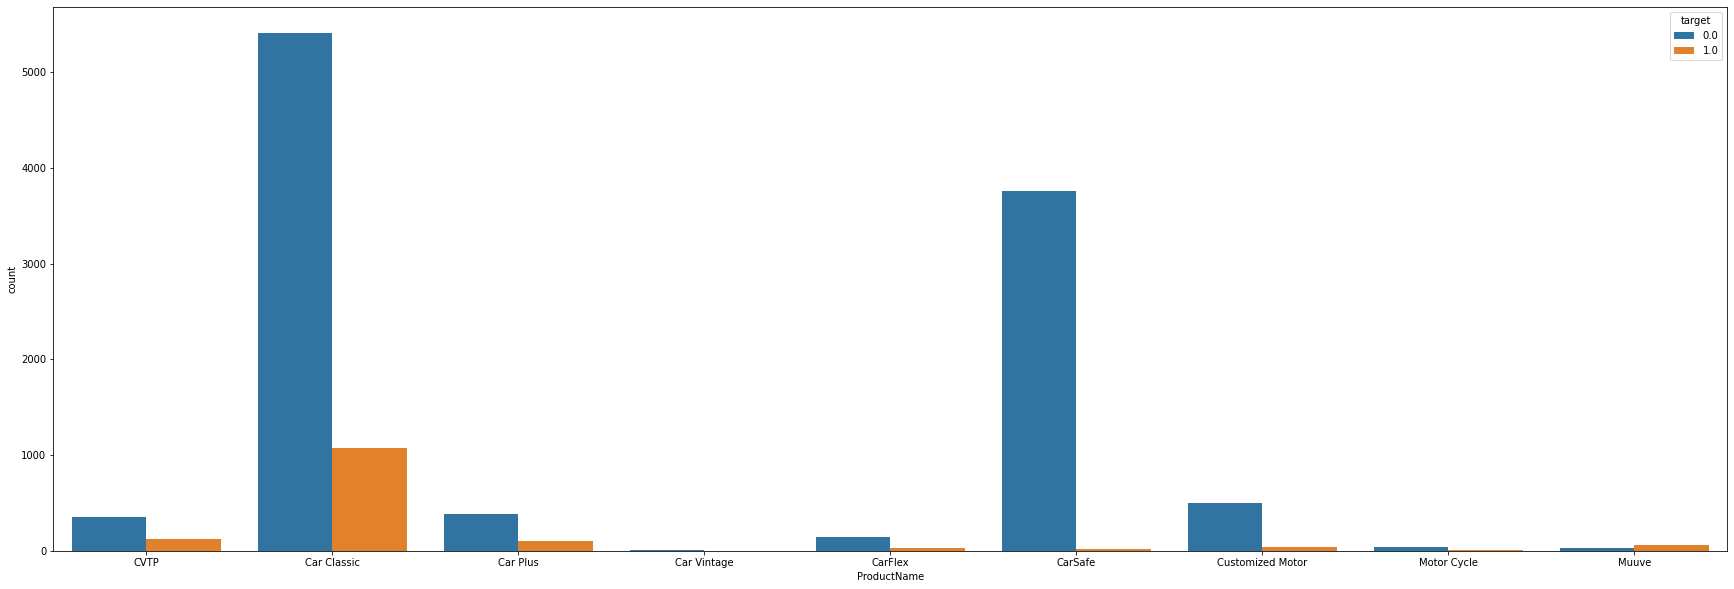

In [32]:
plt.figure(figsize=(30,10))
sns.countplot("ProductName", hue='target',data=all_data)

**Clients who are most likely to make a car insurance claim:**
* **are male**
* **own a saloon car (or jeep)**
* **are from Lagos**
* **have a 'Car Classic' insurance policy.**

In [33]:
all_data['LGA_Name'].value_counts()

Victoria Island    1284
Ikeja               438
Surulere            306
Abuja Municipal     257
Lagos Mainland      245
                   ... 
Isoko North           1
Isoko south           1
Iwo                   1
Katcha                1
Ilesha                1
Name: LGA_Name, Length: 270, dtype: int64

In [34]:
all_data['LGA_Name']=all_data.LGA_Name.replace({'LGA':np.NaN})
all_data.LGA_Name.fillna(np.NaN,inplace =True) 

In [35]:
all_data['State'] = all_data['State'].astype('category')
all_data['Gender'] = all_data['Gender'].astype('category')
all_data['Car_Category'] = all_data['Car_Category'].astype('category')
all_data['LGA_Name'] = all_data['LGA_Name'].astype('category')

####Numerical variables

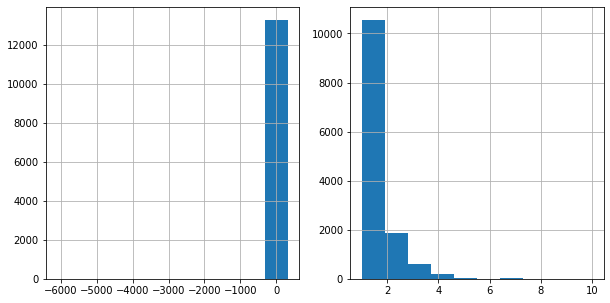

In [36]:
plt.figure(figsize=(10,5))
for i in enumerate(["Age", "No_Pol"]):
  plt.subplot(1, 2, i[0]+1)
  all_data[i[1]].hist()
plt.show()

In [ ]:
# Descriptive statistics
all_data.select_dtypes(include=['int64', 'float64']).describe()

,Age,No_Pol,target
count,13281.000000,13281.000000,12079.000000
mean,42.375574,1.302763,0.120457
std,93.170951,0.723195,0.325509
min,-6099.000000,1.000000,0.000000
25%,35.000000,1.000000,0.000000
50%,41.000000,1.000000,0.000000
75%,50.000000,1.000000,0.000000
max,320.000000,10.000000,1.000000


**The 'Age' column contains extreme values as the maximum age is 320 and the minimum is -6099.**

#### Replacing outliers with NaN

In [37]:
all_data['Age'] = np.where(all_data['Age'].between(-6099,1), np.NaN, all_data['Age'])
all_data['Age'] = np.where(all_data['Age'].between(90,320), np.NaN, all_data['Age'])
all_data['Age'] = np.where(all_data['Age'].between(2,18), all_data['Age'].median(), all_data['Age'])

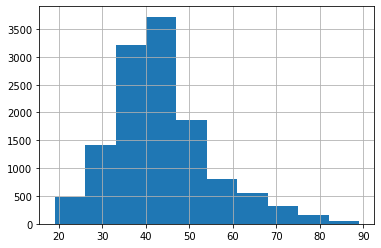

In [38]:
all_data['Age'].hist()

#### Date columns

In [39]:
# Extract date features from the date columns
date_columns = ['Policy Start Date','Policy End Date']
for col in date_cols:
  for date_feature in ['year', 'month', 'day']:
    all_data[col+date_feature] = getattr(all_data[col].dt, date_feature)

all_data['Policy End Dateyear'].value_counts()

2011    13096
2010      177
2012        2
2041        2
2016        2
2037        1
2034        1
Name: Policy End Dateyear, dtype: int64

In [40]:
all_data['Policy End Dateyear'] = np.where(all_data['Policy End Dateyear'].between(2015,2041), np.NaN, all_data['Policy End Dateyear'])

In [41]:
all_data = all_data.drop(columns=['ID','Policy Start Date','Policy End Date', 'First Transaction Date', 'Subject_Car_Colour'])

In [42]:
all_data.head(3)

,Gender,Age,No_Pol,Car_Category,Subject_Car_Make,LGA_Name,State,ProductName,target,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,Policy End Dateyear,Policy End Datemonth,Policy End Dateday,First Transaction Dateyear,First Transaction Datemonth,First Transaction Dateday
0,Male,30.0,1,Saloon,TOYOTA,NaN,NaN,Car Classic,0.0,2010,5,14,2011.0,5,13,2010,5,14
1,Female,79.0,1,JEEP,TOYOTA,NaN,NaN,Car Classic,1.0,2010,11,29,2011.0,11,28,2010,11,29
2,Male,43.0,1,Saloon,TOYOTA,NaN,NaN,Car Classic,0.0,2010,3,21,2011.0,3,20,2010,3,21


# Missing values treatment¶


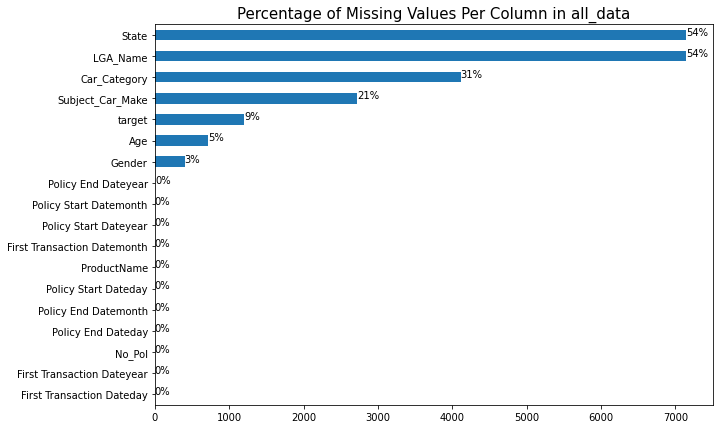

In [43]:
# Check if there any missing values in all_data 
ax = all_data.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in all_data', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/all_data.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y)) 

In [44]:
#Replacing missing values with the mode
all_data['State'].fillna((all_data['State'].mode()[0]), inplace=True)
all_data['Car_Category'].fillna((all_data['Car_Category'].mode()[0]), inplace=True)
all_data['Subject_Car_Make'].fillna((all_data['Subject_Car_Make'].mode()[0]), inplace=True)
all_data['Gender'].fillna((all_data['Gender'].mode()[0]), inplace=True)
all_data['LGA_Name'].fillna((all_data['LGA_Name'].mode()[0]), inplace=True)


#Replacing "Age" missing values with the median
all_data['Age'].fillna((all_data['Age'].median()), inplace=True)

In [45]:
# Confirm that there aren't any missing values
all_data.isna().sum()

Gender                            0
Age                               0
No_Pol                            0
Car_Category                      0
Subject_Car_Make                  0
LGA_Name                          0
State                             0
ProductName                       0
target                         1202
Policy Start Dateyear             0
Policy Start Datemonth            0
Policy Start Dateday              0
Policy End Dateyear               6
Policy End Datemonth              0
Policy End Dateday                0
First Transaction Dateyear        0
First Transaction Datemonth       0
First Transaction Dateday         0
dtype: int64

#Machine Learning

### **Separate train and test data from the combined dataframe**

In [46]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# Create target variable
y = train['target']
# Create feature variable
X = train.drop(columns=['target'], axis=1)


test = test.drop(columns=['target'], axis=1) 

print("X shape: ", X.shape)
print("y shape: ", y.shape)
print("test shape: ", test.shape)

X shape:  (12079, 17)
y shape:  (12079,)
test shape:  (1202, 17)


In [48]:
# Evaluation function 
def evaluate(ytest, ypred, y_predproba): 
  print("Acuracy", accuracy_score(ytest, ypred))
  print("_"*10)
  print("Recall", recall_score(ytest, ypred))
  print("_"*10)
  print("F1 Score", f1_score(ytest, ypred))
  print("_"*10)

  confusion = confusion_matrix(ytest, ypred)
  group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in
                  confusion.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in
                      confusion.flatten()/np.sum(confusion)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  matrix = sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')
  matrix
  figsize=(10, 6)

  fpr, tpr, thresholds = roc_curve(ytest, y_predproba)
  auc = roc_auc_score(ytest, y_predproba)
  plt.figure(figsize=(8,5))

  # Plot the ROC curve
  plt.plot(fpr,tpr,label="AUC="+str(auc))

  # Add labels and diagonal line
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")

  plt.legend(loc=4)
  plt.plot([0, 1], [0, 1], "k--")
  plt.show()
  return

In [49]:
lgbm = LGBMClassifier(learning_rate=0.22,n_estimators = 95,cat_smooth=10,
                               reg_alpha=0.0 ,metrics='binary_error'
                               ,scale_pos_weight= 3.6,max_depth=16,num_leaves=49,reg_lambda=0.3)

catboost = CatBoostClassifier(n_estimators=10000, max_depth=6, eval_metric='F1', reg_lambda = 370, task_type="GPU", devices='0:1')

In [61]:
def training_model(model, modelName, train, test):

  auc_scores = []
  f1_scores = []
  kf = StratifiedKFold(n_splits = 10)
  y_preds = np.zeros(train.shape[0])
  test_preds = np.zeros(test.shape[0])

  def lightgbm_(x_train, x_test, y_train, y_test, test_preds):
    model.fit(x_train, y_train, eval_metric="binary_error",
                           eval_set=[(x_test, y_test)], verbose = True)
    y_pred_proba = model.predict_proba(x_test, num_iteration = model.best_iteration_)[:,1] 
    y_pred = model.predict(x_test, num_iteration = model.best_iteration_)
    y_preds[test_index] = y_pred_proba 
    test_preds += model.predict_proba(test, num_iteration = model.best_iteration_)[:,1]
    return y_pred_proba, y_pred

  def catboost_(x_train, x_test, y_train, y_test, test_preds):
    model.fit(x_train,y_train,eval_set=[(x_test,y_test)],early_stopping_rounds=500,
                           verbose=50,use_best_model=True)
    y_pred_proba = model.predict_proba(x_test)[:,1] 
    y_pred = model.predict(x_test)
    y_preds[test_index] = y_pred_proba 
    test_preds += model.predict_proba(test)[:,1]
    return y_pred_proba, y_pred

  for count, (train_index, test_index) in enumerate(kf.split(X, y)):
      x_train,x_test = X.iloc[train_index], X.iloc[test_index]
      y_train,y_test = y.iloc[train_index], y.iloc[test_index]
      print(f"================================Fold {count+1}====================================")

      if modelName == 'lightgbm':
        y_pred_proba, y_pred = lightgbm_(x_train, x_test, y_train, y_test, test_preds)
      elif modelName == 'catboost':
        y_pred_proba, y_pred = catboost_(x_train, x_test, y_train, y_test, test_preds)
        
      evaluate(y_test, y_pred, y_pred_proba)
      print('\nValidation auc:', roc_auc_score(y_test, y_pred_proba))

      auc_scores.append(roc_auc_score(y_test, y_pred_proba))
      f1_scores.append(f1_score(y_test, y_pred))
  print('Mean AUC ', np.mean(auc_scores))
  print('Mean f1 ', np.mean(f1_scores))
  return y_preds, test_preds/10

================================Fold 1====================================
[1]	valid_0's binary_error: 0.120033
[2]	valid_0's binary_error: 0.11755
[3]	valid_0's binary_error: 0.119205
[4]	valid_0's binary_error: 0.124172
[5]	valid_0's binary_error: 0.126656
[6]	valid_0's binary_error: 0.139073
[7]	valid_0's binary_error: 0.164735
[8]	valid_0's binary_error: 0.172185
[9]	valid_0's binary_error: 0.182119
[10]	valid_0's binary_error: 0.186258
[11]	valid_0's binary_error: 0.187086
[12]	valid_0's binary_error: 0.188742
[13]	valid_0's binary_error: 0.191225
[14]	valid_0's binary_error: 0.198675
[15]	valid_0's binary_error: 0.19702
[16]	valid_0's binary_error: 0.19702
[17]	valid_0's binary_error: 0.18957
[18]	valid_0's binary_error: 0.192053
[19]	valid_0's binary_error: 0.193709
[20]	valid_0's binary_error: 0.192053
[21]	valid_0's binary_error: 0.190397
[22]	valid_0's binary_error: 0.188742
[23]	valid_0's binary_error: 0.18957
[24]	valid_0's binary_error: 0.188742
[25]	valid_0's binary_error

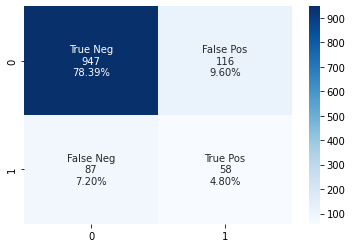

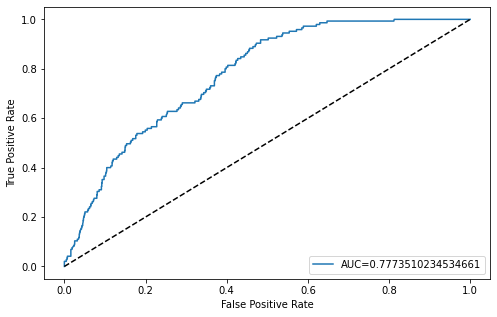


Validation auc: 0.7773510234534661
================================Fold 2====================================
[1]	valid_0's binary_error: 0.120033
[2]	valid_0's binary_error: 0.118377
[3]	valid_0's binary_error: 0.119205
[4]	valid_0's binary_error: 0.13245
[5]	valid_0's binary_error: 0.137417
[6]	valid_0's binary_error: 0.158113
[7]	valid_0's binary_error: 0.172185
[8]	valid_0's binary_error: 0.169702
[9]	valid_0's binary_error: 0.173841
[10]	valid_0's binary_error: 0.179636
[11]	valid_0's binary_error: 0.18543
[12]	valid_0's binary_error: 0.191225
[13]	valid_0's binary_error: 0.188742
[14]	valid_0's binary_error: 0.190397
[15]	valid_0's binary_error: 0.190397
[16]	valid_0's binary_error: 0.18957
[17]	valid_0's binary_error: 0.192053
[18]	valid_0's binary_error: 0.196192
[19]	valid_0's binary_error: 0.196192
[20]	valid_0's binary_error: 0.192881
[21]	valid_0's binary_error: 0.195364
[22]	valid_0's binary_error: 0.192053
[23]	valid_0's binary_error: 0.191225
[24]	valid_0's binary_error

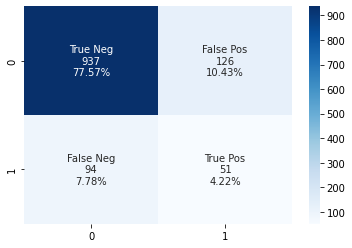

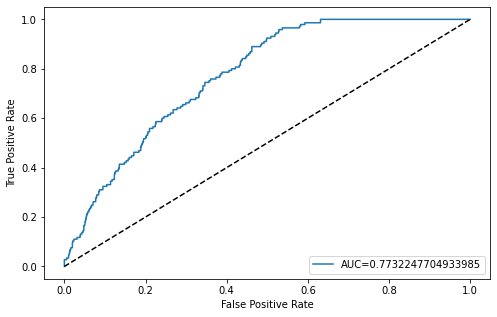


Validation auc: 0.7732247704933985
================================Fold 3====================================
[1]	valid_0's binary_error: 0.120033
[2]	valid_0's binary_error: 0.119205
[3]	valid_0's binary_error: 0.11755
[4]	valid_0's binary_error: 0.127483
[5]	valid_0's binary_error: 0.138245
[6]	valid_0's binary_error: 0.143212
[7]	valid_0's binary_error: 0.149834
[8]	valid_0's binary_error: 0.163079
[9]	valid_0's binary_error: 0.175497
[10]	valid_0's binary_error: 0.181291
[11]	valid_0's binary_error: 0.182947
[12]	valid_0's binary_error: 0.186258
[13]	valid_0's binary_error: 0.187914
[14]	valid_0's binary_error: 0.191225
[15]	valid_0's binary_error: 0.190397
[16]	valid_0's binary_error: 0.18957
[17]	valid_0's binary_error: 0.191225
[18]	valid_0's binary_error: 0.191225
[19]	valid_0's binary_error: 0.187914
[20]	valid_0's binary_error: 0.18957
[21]	valid_0's binary_error: 0.187914
[22]	valid_0's binary_error: 0.186258
[23]	valid_0's binary_error: 0.186258
[24]	valid_0's binary_error

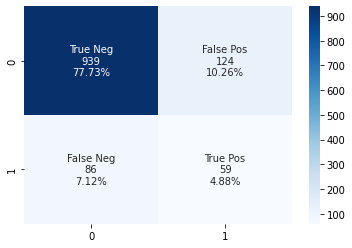

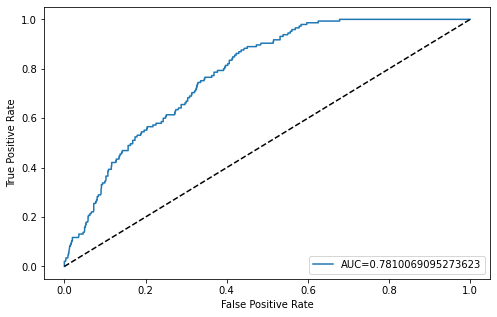


Validation auc: 0.7810069095273623
================================Fold 4====================================
[1]	valid_0's binary_error: 0.120033
[2]	valid_0's binary_error: 0.116722
[3]	valid_0's binary_error: 0.115894
[4]	valid_0's binary_error: 0.115894
[5]	valid_0's binary_error: 0.124172
[6]	valid_0's binary_error: 0.129139
[7]	valid_0's binary_error: 0.139073
[8]	valid_0's binary_error: 0.148179
[9]	valid_0's binary_error: 0.147351
[10]	valid_0's binary_error: 0.155629
[11]	valid_0's binary_error: 0.157285
[12]	valid_0's binary_error: 0.163907
[13]	valid_0's binary_error: 0.165563
[14]	valid_0's binary_error: 0.173841
[15]	valid_0's binary_error: 0.173013
[16]	valid_0's binary_error: 0.171358
[17]	valid_0's binary_error: 0.176325
[18]	valid_0's binary_error: 0.177152
[19]	valid_0's binary_error: 0.175497
[20]	valid_0's binary_error: 0.177152
[21]	valid_0's binary_error: 0.176325
[22]	valid_0's binary_error: 0.178808
[23]	valid_0's binary_error: 0.177152
[24]	valid_0's binary_er

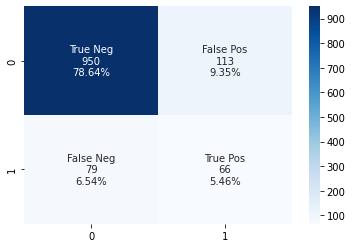

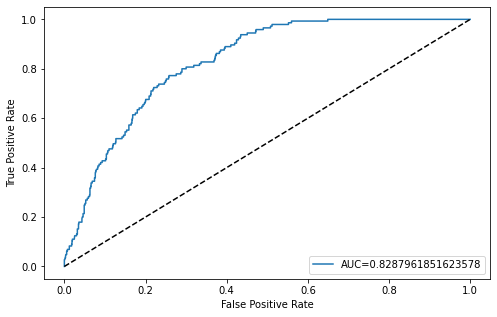


Validation auc: 0.8287961851623578
================================Fold 5====================================
[1]	valid_0's binary_error: 0.120861
[2]	valid_0's binary_error: 0.119205
[3]	valid_0's binary_error: 0.114238
[4]	valid_0's binary_error: 0.125
[5]	valid_0's binary_error: 0.137417
[6]	valid_0's binary_error: 0.139073
[7]	valid_0's binary_error: 0.145695
[8]	valid_0's binary_error: 0.153974
[9]	valid_0's binary_error: 0.169702
[10]	valid_0's binary_error: 0.173841
[11]	valid_0's binary_error: 0.176325
[12]	valid_0's binary_error: 0.176325
[13]	valid_0's binary_error: 0.177152
[14]	valid_0's binary_error: 0.182947
[15]	valid_0's binary_error: 0.192053
[16]	valid_0's binary_error: 0.187914
[17]	valid_0's binary_error: 0.187914
[18]	valid_0's binary_error: 0.191225
[19]	valid_0's binary_error: 0.188742
[20]	valid_0's binary_error: 0.182947
[21]	valid_0's binary_error: 0.178808
[22]	valid_0's binary_error: 0.17798
[23]	valid_0's binary_error: 0.176325
[24]	valid_0's binary_error:

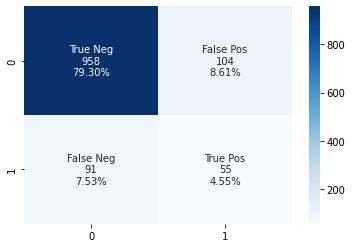

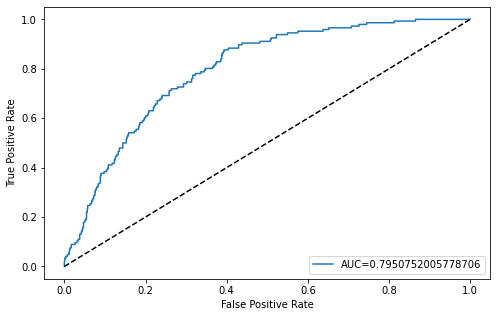


Validation auc: 0.7950752005778706
================================Fold 6====================================
[1]	valid_0's binary_error: 0.120861
[2]	valid_0's binary_error: 0.115894
[3]	valid_0's binary_error: 0.113411
[4]	valid_0's binary_error: 0.10596
[5]	valid_0's binary_error: 0.115894
[6]	valid_0's binary_error: 0.131623
[7]	valid_0's binary_error: 0.152318
[8]	valid_0's binary_error: 0.156457
[9]	valid_0's binary_error: 0.164735
[10]	valid_0's binary_error: 0.180464
[11]	valid_0's binary_error: 0.178808
[12]	valid_0's binary_error: 0.177152
[13]	valid_0's binary_error: 0.17798
[14]	valid_0's binary_error: 0.175497
[15]	valid_0's binary_error: 0.174669
[16]	valid_0's binary_error: 0.175497
[17]	valid_0's binary_error: 0.177152
[18]	valid_0's binary_error: 0.179636
[19]	valid_0's binary_error: 0.180464
[20]	valid_0's binary_error: 0.180464
[21]	valid_0's binary_error: 0.181291
[22]	valid_0's binary_error: 0.182119
[23]	valid_0's binary_error: 0.181291
[24]	valid_0's binary_erro

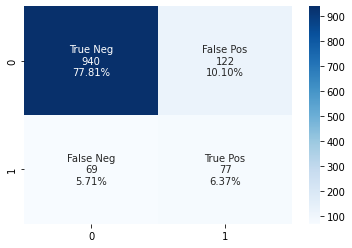

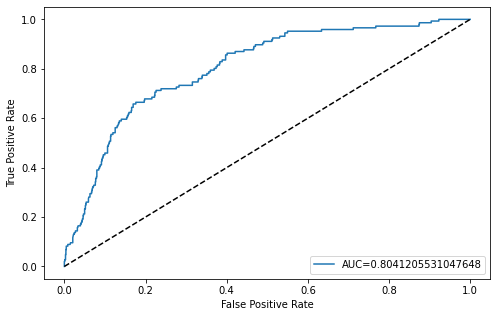


Validation auc: 0.8041205531047648
================================Fold 7====================================
[1]	valid_0's binary_error: 0.120861
[2]	valid_0's binary_error: 0.121689
[3]	valid_0's binary_error: 0.114238
[4]	valid_0's binary_error: 0.124172
[5]	valid_0's binary_error: 0.135762
[6]	valid_0's binary_error: 0.143212
[7]	valid_0's binary_error: 0.152318
[8]	valid_0's binary_error: 0.159768
[9]	valid_0's binary_error: 0.171358
[10]	valid_0's binary_error: 0.17798
[11]	valid_0's binary_error: 0.191225
[12]	valid_0's binary_error: 0.192053
[13]	valid_0's binary_error: 0.198675
[14]	valid_0's binary_error: 0.197848
[15]	valid_0's binary_error: 0.193709
[16]	valid_0's binary_error: 0.195364
[17]	valid_0's binary_error: 0.202815
[18]	valid_0's binary_error: 0.197848
[19]	valid_0's binary_error: 0.19702
[20]	valid_0's binary_error: 0.197848
[21]	valid_0's binary_error: 0.201987
[22]	valid_0's binary_error: 0.203642
[23]	valid_0's binary_error: 0.202815
[24]	valid_0's binary_erro

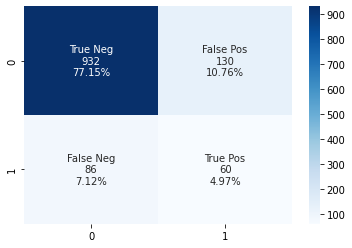

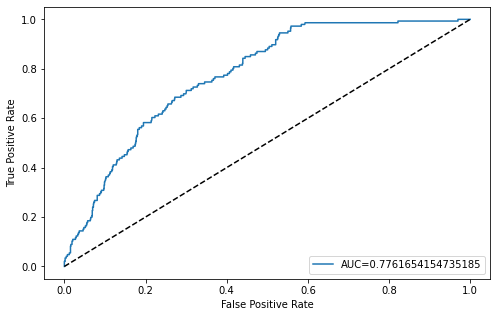


Validation auc: 0.7761654154735185
================================Fold 8====================================
[1]	valid_0's binary_error: 0.120861
[2]	valid_0's binary_error: 0.120861
[3]	valid_0's binary_error: 0.115066
[4]	valid_0's binary_error: 0.122517
[5]	valid_0's binary_error: 0.13245
[6]	valid_0's binary_error: 0.139901
[7]	valid_0's binary_error: 0.148179
[8]	valid_0's binary_error: 0.158113
[9]	valid_0's binary_error: 0.161424
[10]	valid_0's binary_error: 0.163079
[11]	valid_0's binary_error: 0.17053
[12]	valid_0's binary_error: 0.176325
[13]	valid_0's binary_error: 0.17798
[14]	valid_0's binary_error: 0.179636
[15]	valid_0's binary_error: 0.181291
[16]	valid_0's binary_error: 0.181291
[17]	valid_0's binary_error: 0.178808
[18]	valid_0's binary_error: 0.180464
[19]	valid_0's binary_error: 0.179636
[20]	valid_0's binary_error: 0.179636
[21]	valid_0's binary_error: 0.180464
[22]	valid_0's binary_error: 0.181291
[23]	valid_0's binary_error: 0.183775
[24]	valid_0's binary_error

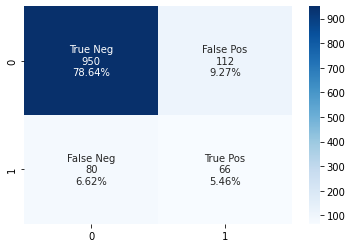

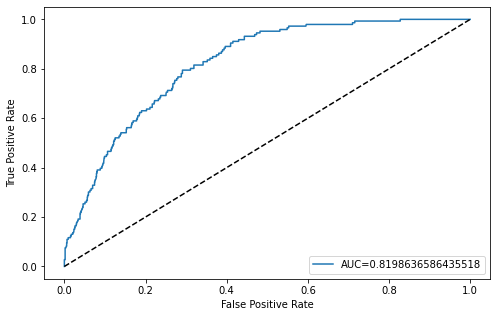


Validation auc: 0.8198636586435518
================================Fold 9====================================
[1]	valid_0's binary_error: 0.120861
[2]	valid_0's binary_error: 0.11755
[3]	valid_0's binary_error: 0.115066
[4]	valid_0's binary_error: 0.122517
[5]	valid_0's binary_error: 0.122517
[6]	valid_0's binary_error: 0.135762
[7]	valid_0's binary_error: 0.146523
[8]	valid_0's binary_error: 0.153146
[9]	valid_0's binary_error: 0.159768
[10]	valid_0's binary_error: 0.17053
[11]	valid_0's binary_error: 0.168874
[12]	valid_0's binary_error: 0.168046
[13]	valid_0's binary_error: 0.171358
[14]	valid_0's binary_error: 0.172185
[15]	valid_0's binary_error: 0.173841
[16]	valid_0's binary_error: 0.173841
[17]	valid_0's binary_error: 0.174669
[18]	valid_0's binary_error: 0.171358
[19]	valid_0's binary_error: 0.172185
[20]	valid_0's binary_error: 0.17053
[21]	valid_0's binary_error: 0.171358
[22]	valid_0's binary_error: 0.173841
[23]	valid_0's binary_error: 0.17053
[24]	valid_0's binary_error:

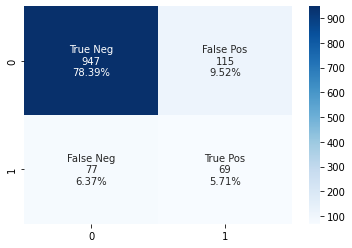

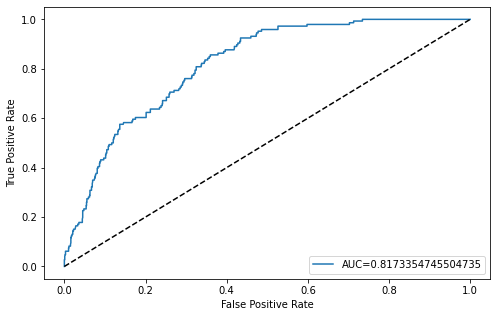


Validation auc: 0.8173354745504735
================================Fold 10====================================
[1]	valid_0's binary_error: 0.120133
[2]	valid_0's binary_error: 0.119304
[3]	valid_0's binary_error: 0.118476
[4]	valid_0's binary_error: 0.125104
[5]	valid_0's binary_error: 0.13256
[6]	valid_0's binary_error: 0.136703
[7]	valid_0's binary_error: 0.137531
[8]	valid_0's binary_error: 0.147473
[9]	valid_0's binary_error: 0.169014
[10]	valid_0's binary_error: 0.177299
[11]	valid_0's binary_error: 0.173985
[12]	valid_0's binary_error: 0.178128
[13]	valid_0's binary_error: 0.185584
[14]	valid_0's binary_error: 0.186413
[15]	valid_0's binary_error: 0.186413
[16]	valid_0's binary_error: 0.183927
[17]	valid_0's binary_error: 0.180613
[18]	valid_0's binary_error: 0.183099
[19]	valid_0's binary_error: 0.179785
[20]	valid_0's binary_error: 0.177299
[21]	valid_0's binary_error: 0.176471
[22]	valid_0's binary_error: 0.176471
[23]	valid_0's binary_error: 0.176471
[24]	valid_0's binary_er

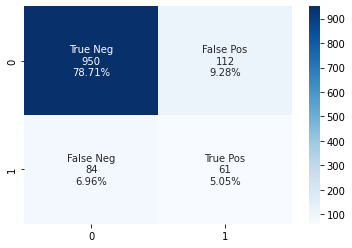

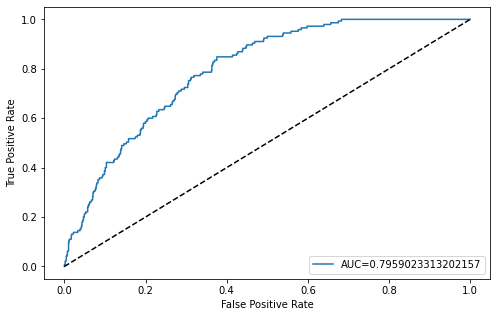


Validation auc: 0.7959023313202157
Mean AUC  0.796884152230698
Mean f1  0.3820982485713493


In [62]:
y_preds_lgbm, test_preds_lgbm = training_model(lgbm, "lightgbm", train, test)

In [ ]:
test_preds_lgbm

array([0.13061384, 0.06893737, 0.04513665, ..., 0.33842979, 0.04673997,
       0.67915136])

In [ ]:
y_preds_cat, test_preds_cat = training_model(catboost, "catboost", train, test)

In [ ]:
predictions = ss.copy()(
predictions.target = (test_preds_lgbm*0.8) + (test_preds_cat*0.2)

In [ ]:
for i in range(len(predictions.target)):
  if predictions.target[i] >= 0.5:
    predictions.target[i] = 1
  else:
    predictions.target[i] = 0
predictions

In [ ]:
predictions.to_csv('predictions_autoinland.csv', index=False)